<a href="https://colab.research.google.com/github/xhavien/CCDATSCL_COM221_PROJECT/blob/main/CCDATSCL_COM221_PROJECT1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Environment Setup and Data Loading

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Load the dataset
# Ensure the CSV file is uploaded to your Colab session
df = pd.read_csv('final_personalized_spotify_history_v2.csv')

# Display initial information
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 894 entries, 0 to 893
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   spotify_track_uri  894 non-null    object
 1   ts                 894 non-null    object
 2   platform           894 non-null    object
 3   ms_played          894 non-null    int64 
 4   track_name         894 non-null    object
 5   artist_name        894 non-null    object
 6   album_name         894 non-null    object
 7   reason_start       894 non-null    object
 8   reason_end         894 non-null    object
 9   shuffle            894 non-null    bool  
 10  skipped            894 non-null    bool  
dtypes: bool(2), int64(1), object(8)
memory usage: 64.7+ KB
None


,spotify_track_uri,ts,platform,ms_played,track_name,artist_name,album_name,reason_start,reason_end,shuffle,skipped
0,spotify:track:1624164559344481349,1/2/2026 9:00,windows,11435,Metro Boomin Track,Metro Boomin,Metro Boomin Release,appload,backbtn,False,True
1,spotify:track:5mYfTpxY3rWshvD0G4qC5v,1/2/2026 9:00,android,161248,IDGAF (feat. Yeat),Drake,For All The Dogs,fwdbtn,trackdone,False,False
2,spotify:track:18067058559603401579,1/2/2026 9:03,web player,221856,Drake Song,Drake,Drake Album,trackdone,trackdone,True,False
3,spotify:track:4584321927261482156,1/2/2026 9:06,web player,239575,The Weeknd Track,The Weeknd,The Weeknd Release,fwdbtn,trackdone,True,False
4,spotify:track:15475763429782791804,1/2/2026 9:11,android,190372,Drake Song,Drake,Drake Album,appload,trackdone,False,False


Data Cleaning and Feature Engineering

In [11]:
# Convert timestamp to datetime
df['ts'] = pd.to_datetime(df['ts'])

# Extract temporal features
df['hour'] = df['ts'].dt.hour
df['day_of_week'] = df['ts'].dt.day_name()

# Check for missing values
print("Missing values per column:\n", df.isnull().sum())

Missing values per column:
 spotify_track_uri    0
ts                   0
platform             0
ms_played            0
track_name           0
artist_name          0
album_name           0
reason_start         0
reason_end           0
shuffle              0
skipped              0
hour                 0
day_of_week          0
dtype: int64


Exploratory Data Analysis (EDA) and Visualization

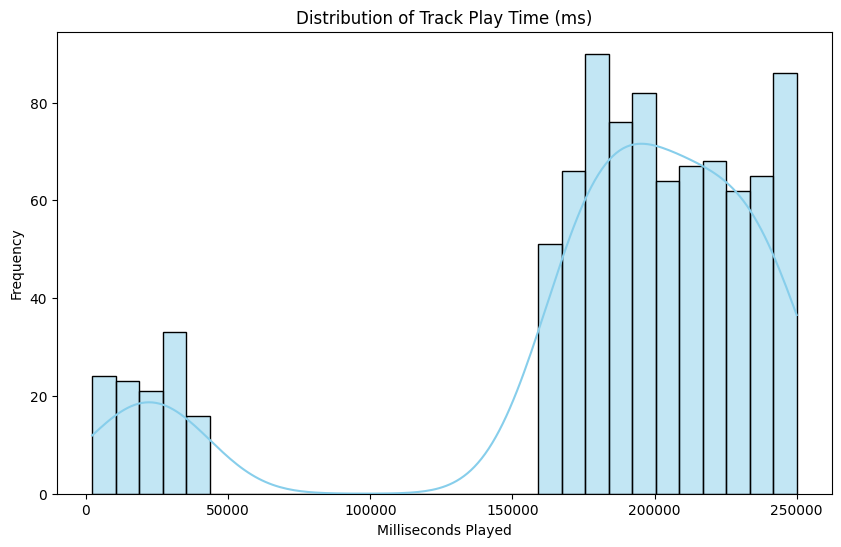

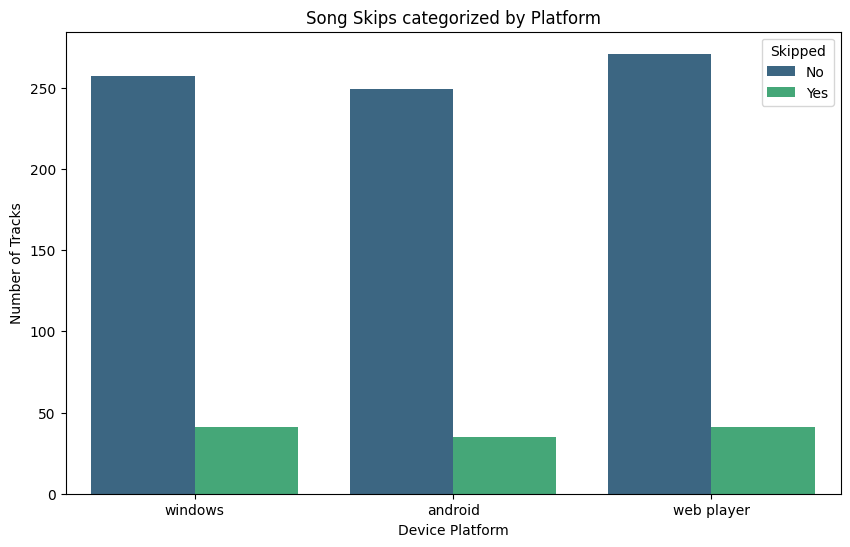

In [12]:
# Distribution of play time
plt.figure(figsize=(10, 6))
sns.histplot(df['ms_played'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Track Play Time (ms)')
plt.xlabel('Milliseconds Played')
plt.ylabel('Frequency')
plt.show()

# Skip counts by platform
plt.figure(figsize=(10, 6))
sns.countplot(x='platform', hue='skipped', data=df, palette='viridis')
plt.title('Song Skips categorized by Platform')
plt.xlabel('Device Platform')
plt.ylabel('Number of Tracks')
plt.legend(title='Skipped', labels=['No', 'Yes'])
plt.show()

Statistical Testing

In [13]:
# Create a contingency table for Shuffle vs Skipped
contingency_table = pd.crosstab(df['shuffle'], df['skipped'])
print("Contingency Table:\n", contingency_table)

# Run Chi-Square Test
chi2, p_val, dof, expected = chi2_contingency(contingency_table)

print(f"\nChi-Square Statistic: {chi2:.4f}")
print(f"P-value: {p_val:.4f}")

if p_val < 0.05:
    print("Result: Statistically significant relationship found.")
else:
    print("Result: No statistically significant relationship found.")

Contingency Table:
 skipped  False  True 
shuffle              
False      367     60
True       410     57

Chi-Square Statistic: 0.5158
P-value: 0.4726
Result: No statistically significant relationship found.


Machine Learning Model Training

In [14]:
# Feature Selection
features = ['platform', 'shuffle', 'hour', 'reason_start']
X = pd.get_dummies(df[features], drop_first=True)
y = df['skipped'].astype(int)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train Random Forest with balanced class weights
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

print("Model Training Complete.")

Model Training Complete.


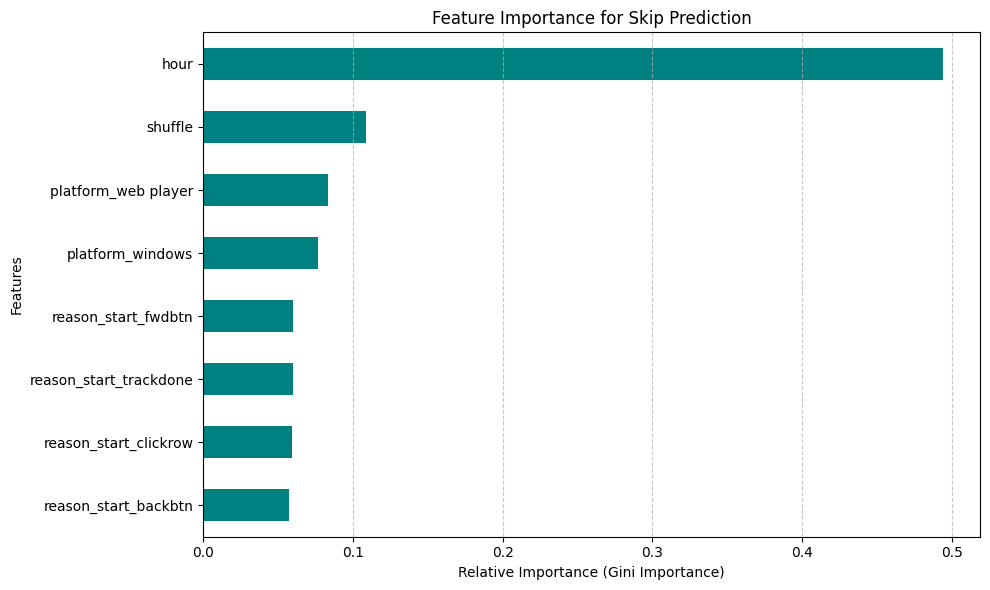

In [15]:
# --- Cell: Feature Importance Analysis ---
import pandas as pd
import matplotlib.pyplot as plt

# Get importance levels from the trained random forest model
importances = rf_model.feature_importances_
feature_names = X.columns
feat_importances = pd.Series(importances, index=feature_names).sort_values(ascending=True)

# Visualize the importance of each feature
plt.figure(figsize=(10, 6))
feat_importances.plot(kind='barh', color='teal')
plt.title('Feature Importance for Skip Prediction')
plt.xlabel('Relative Importance (Gini Importance)')
plt.ylabel('Features')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save the figure for Overleaf
plt.savefig('feature_importance.png')
plt.show()

Model Evaluation

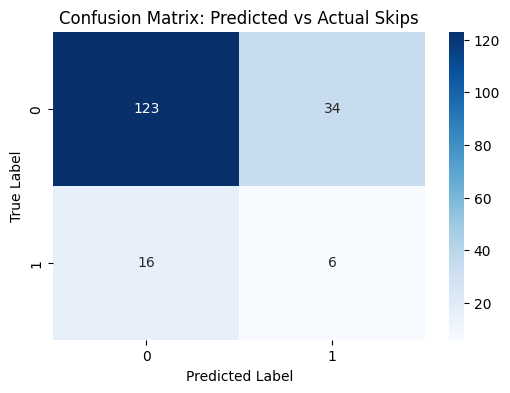

Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.78      0.83       157
           1       0.15      0.27      0.19        22

    accuracy                           0.72       179
   macro avg       0.52      0.53      0.51       179
weighted avg       0.79      0.72      0.75       179



In [16]:
# Confusion Matrix visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix: Predicted vs Actual Skips')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Detailed Metrics
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# Load data
df = pd.read_csv('final_personalized_spotify_history_v2.csv')
df['ts'] = pd.to_datetime(df['ts'])
df['hour'] = df['ts'].dt.hour

# 1. Distribution of Track Play Time
plt.figure(figsize=(8, 5))
sns.histplot(df['ms_played'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Track Play Time (ms)')
plt.xlabel('Milliseconds Played')
plt.ylabel('Frequency')
plt.savefig('play_time_dist.png')
plt.close()

# 2. Song Skips by Platform
plt.figure(figsize=(8, 5))
sns.countplot(x='platform', hue='skipped', data=df, palette='viridis')
plt.title('Song Skips by Platform')
plt.xlabel('Platform')
plt.ylabel('Count')
plt.legend(title='Skipped', labels=['No', 'Yes'])
plt.savefig('skips_platform.png')
plt.close()

# Prepare for Machine Learning
features = ['platform', 'shuffle', 'hour', 'reason_start']
X = pd.get_dummies(df[features], drop_first=True)
y = df['skipped'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

# 3. Feature Importance Plot
importances = rf_model.feature_importances_
feature_names = X.columns
feat_importances = pd.Series(importances, index=feature_names).sort_values(ascending=True)

plt.figure(figsize=(8, 5))
feat_importances.plot(kind='barh', color='teal')
plt.title('Feature Importance for Skip Prediction')
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.close()

# 4. Confusion Matrix Plot
y_pred = rf_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix: Predicted vs Actual Skips')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('confusion_matrix.png')
plt.close()

print("All figures saved as .png files.")

All figures saved as .png files.
